# Data Exploration

In [1]:
import requests
import pandas as pd
import json
import praw
from praw.models import MoreComments
import re
from datetime import date, timedelta
import time
import os
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
all_data = pd.read_csv("../output/additionalinfo.csv")

In [3]:
all_data.head()

,index,id,comments,subreddit,curlpattern,porosity,density,thickness,cantu,cd,...,giovanni,kc,maui,mt,nym,pantene,sm,suave,tj,tresemme
0,Mediumnotch,eh00u5,"bleaching my hair basically killed my waves, t...",r/wavyhair,NaN,NaN,NaN,NaN,False,False,...,False,False,False,False,False,False,False,False,False,False
1,Sharkelberryfinn,eh00u5,you might be able to get away with just using ...,r/wavyhair,NaN,NaN,NaN,coarse,False,False,...,False,False,False,False,False,False,False,False,False,False
2,SleepyOne123,eh00u5,olaplex 3 every week has been a game changer f...,r/wavyhair,NaN,NaN,NaN,NaN,False,False,...,False,False,False,False,False,False,False,False,False,False
3,jewolfin,eh00u5,bleached wavy hair (help!)&&&hello all! so i'm...,r/wavyhair,2a 2b,NaN,NaN,NaN,False,False,...,False,False,False,False,False,False,False,False,False,False
4,AMillionFreckles,egtv0c,hair type help- wavy or curly? my top layer wa...,r/wavyhair,3a,NaN,NaN,NaN,False,False,...,False,False,False,False,False,False,False,False,False,False


## Some data cleaning

In [5]:
all_data = all_data.fillna('')

In [12]:
products = list(all_data.columns[list(all_data.columns).index('cantu'):])
products

['cantu',
 'cd',
 'garnier',
 'giovanni',
 'kc',
 'maui',
 'mt',
 'nym',
 'pantene',
 'sm',
 'suave',
 'tj',
 'tresemme']

## Investigative Viz

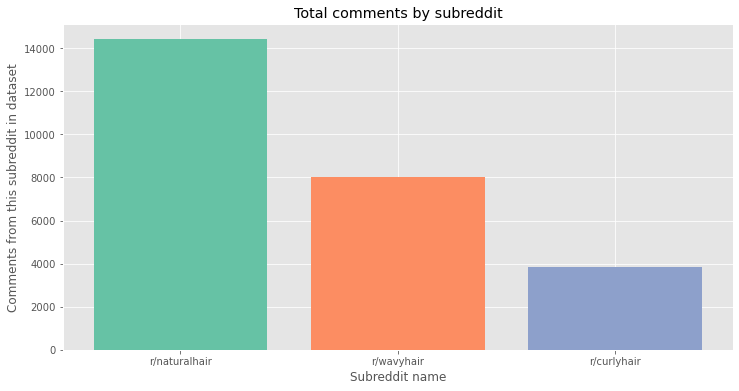

In [13]:
subreddit_counts = all_data.subreddit.value_counts()

plt.bar([i for i in range(3)], list(subreddit_counts), color=sns.color_palette("Set2")[:3])
plt.xlabel("Subreddit name")
plt.ylabel("Comments from this subreddit in dataset")
plt.title("Total comments by subreddit")

plt.xticks([i for i in range(3)], list(subreddit_counts.keys()))

plt.show()

We can see that the number of comments in each community isn't equal, so we'll want to keep that in mind for future analysis

In [14]:
product_color_palette = sns.color_palette("Spectral", n_colors=len(products))

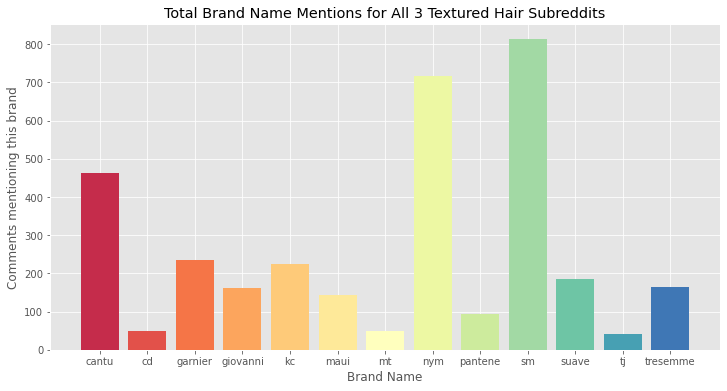

In [15]:
plt.bar([i for i in range(len(products))], all_data[products].sum(), color=product_color_palette)
plt.xlabel("Brand Name")
plt.ylabel("Comments mentioning this brand")
plt.title("Total Brand Name Mentions for All 3 Textured Hair Subreddits")

plt.xticks([i for i in range(len(products))], products)

plt.show()

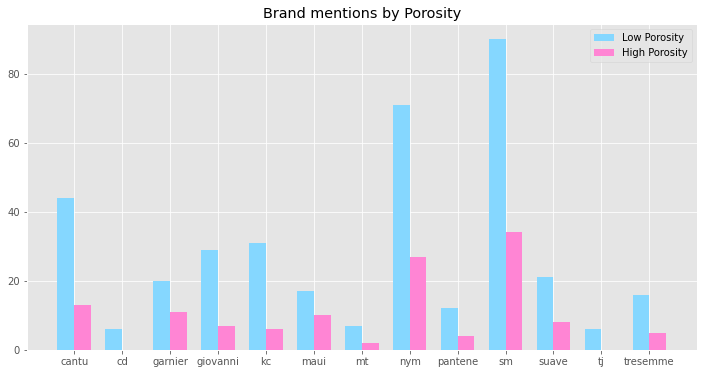

In [16]:
ind = np.arange(len(products))
width = 0.35

plt.bar(ind, all_data[all_data.porosity=='low'][products].sum(), width, label='Low Porosity', color="#85d7ff")
plt.bar(ind + width, all_data[all_data.porosity=='high'][products].sum(), width,
    label='High Porosity', color="#ff85d4")

plt.title('Brand mentions by Porosity')

plt.xticks(ind + width / 2, products)
plt.legend(loc='best')
plt.show()

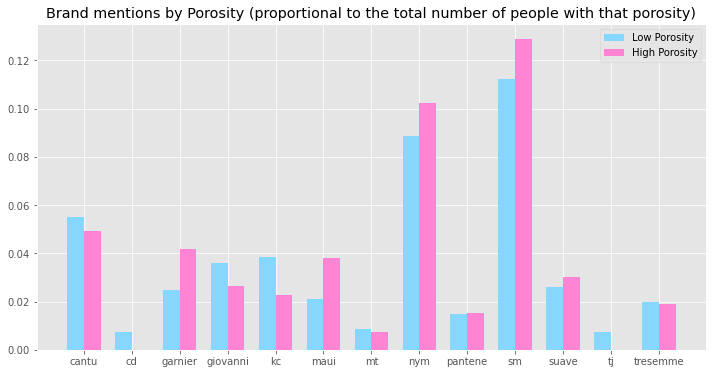

In [17]:
ind = np.arange(len(products))
width = 0.35

plt.bar(ind, all_data[all_data.porosity=='low'][products].sum() / len(all_data[all_data.porosity=='low']), width, label='Low Porosity', color="#85d7ff")
plt.bar(ind + width, all_data[all_data.porosity=='high'][products].sum() / len(all_data[all_data.porosity=='high']), width,
    label='High Porosity', color="#ff85d4")

plt.title('Brand mentions by Porosity (proportional to the total number of people with that porosity)')

plt.xticks(ind + width / 2, products)
plt.legend(loc='best')
plt.show()

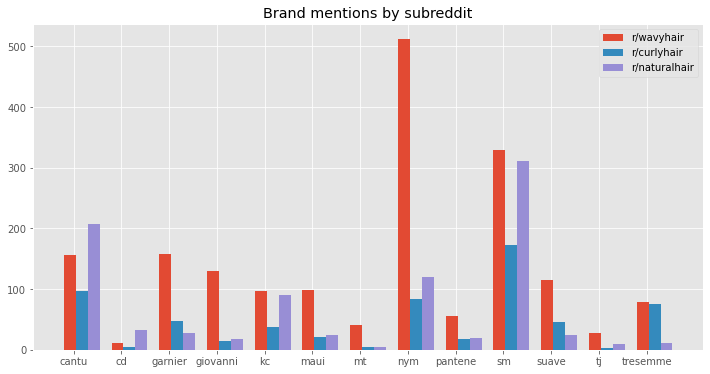

In [58]:
ind = np.arange(len(products))
width = 0.25

plt.bar(ind, all_data[all_data.subreddit=='r/wavyhair'][products].sum(), width, label='r/wavyhair')
plt.bar(ind + width, all_data[all_data.subreddit=='r/curlyhair'][products].sum(), width,
    label='r/curlyhair')
plt.bar(ind + 2*width, all_data[all_data.subreddit=='r/naturalhair'][products].sum(), width,
    label='r/naturalhair')

plt.title('Brand mentions by subreddit')

plt.xticks(ind + width / 3, products)
plt.legend(loc='best')
plt.show()

In [59]:
all_data[(all_data.porosity=='low') & (all_data.thickness=='fine')][products].sum()

cantu       12
cd           0
garnier      8
giovanni    17
kc          12
maui         8
mt           3
nym         40
pantene      5
sm          17
suave        5
tj           3
tresemme     7
dtype: int64

In [60]:
def piechart(brand, column):
    subreddit_counts = all_data[all_data[brand]][column].value_counts()

    # Pie chart, where the slices will be ordered and plotted counter-clockwise:
    labels = list(subreddit_counts.keys())
    sizes = list(subreddit_counts)
    explode = [0.1 if x==max(sizes) else 0 for x in sizes]  # only "explode" the 2nd slice (i.e. 'Hogs')

    fig1, ax1 = plt.subplots()
    ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
            shadow=True, startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.show()

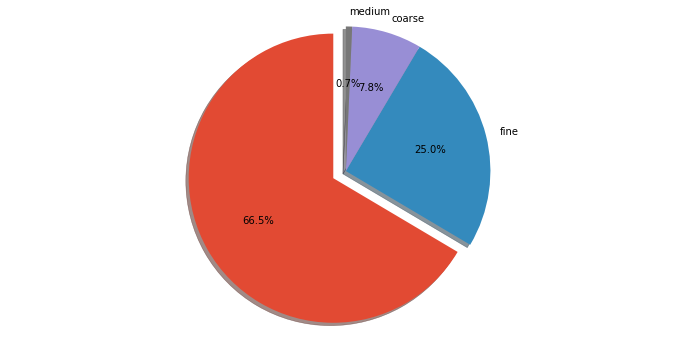

In [61]:
piechart('nym', 'thickness')

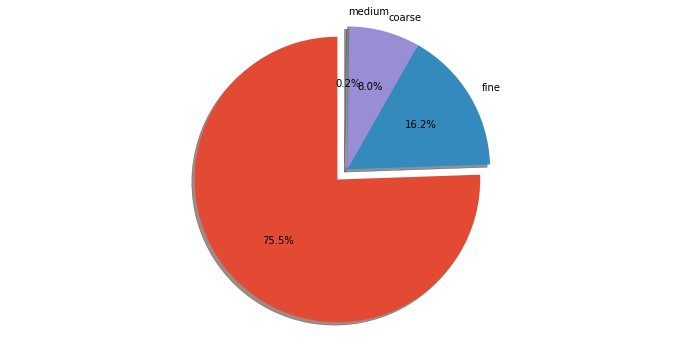

In [62]:
piechart('cantu', 'thickness')

## Chi-sq

### Assumptions
1. *Both characters are categorical*
    We will be looking at categoroical variables
2. All observations are independent.
    Close enough to independent...
3. Cells are mutually exclusive
    This one is met. 
4. Expected value of cells should be 5 or greater in at least 80% of cells
    We can check this quickly

In [19]:
from scipy.stats import chi2_contingency
from itertools import combinations
from itertools import product
from statsmodels.sandbox.stats.multicomp import multipletests

In [30]:
for x in product(['subreddit','porosity','density','thickness'], products):
    attribute=x[0]
    brand=x[1]
    contingency = pd.crosstab(all_data[all_data[attribute] != ""][attribute], all_data[all_data[attribute] != ""][brand])
    chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
    if np.any(ex < 5):
        print("Doesn't meet fourth assumption of Chi-squared: " + attribute + " " + brand)

Doesn't meet fourth assumption of Chi-squared: porosity cd
Doesn't meet fourth assumption of Chi-squared: porosity garnier
Doesn't meet fourth assumption of Chi-squared: porosity giovanni
Doesn't meet fourth assumption of Chi-squared: porosity kc
Doesn't meet fourth assumption of Chi-squared: porosity maui
Doesn't meet fourth assumption of Chi-squared: porosity mt
Doesn't meet fourth assumption of Chi-squared: porosity pantene
Doesn't meet fourth assumption of Chi-squared: porosity suave
Doesn't meet fourth assumption of Chi-squared: porosity tj
Doesn't meet fourth assumption of Chi-squared: porosity tresemme
Doesn't meet fourth assumption of Chi-squared: density cantu
Doesn't meet fourth assumption of Chi-squared: density cd
Doesn't meet fourth assumption of Chi-squared: density garnier
Doesn't meet fourth assumption of Chi-squared: density giovanni
Doesn't meet fourth assumption of Chi-squared: density kc
Doesn't meet fourth assumption of Chi-squared: density maui
Doesn't meet fourth

In [28]:
def run_chisq(attribute, brand):
    contingency = pd.crosstab(all_data[all_data[attribute] != ""][attribute], all_data[all_data[attribute] != ""][brand])
    return(chi2_contingency(contingency))

In [91]:
c, p, dof, expected = run_chisq('subreddit', 'cantu')

In [92]:
p

1.001461280118867e-05

In [164]:
#https://neuhofmo.github.io/chi-square-and-post-hoc-in-python/
def get_asterisks_for_pval(p_val):
    """Receives the p-value and returns asterisks string."""
    if p_val > 0.05:
        p_text = "ns"  # above threshold => not significant
    elif p_val < 1e-4:  
        p_text = '****'
    elif p_val < 1e-3:
        p_text = '***'
    elif p_val < 1e-2:
        p_text = '**'
    else:
        p_text = '*'
    
    return p_text
def chisq_and_posthoc_corrected(df):
    """Receives a dataframe and performs chi2 test and then post hoc.
    Prints the p-values and corrected p-values (after FDR correction)"""
    # start by running chi2 test on the matrix
#     chi2, p, dof, ex = chi2_contingency(df, correction=True)
#     print(f"Chi2 result of the contingency table: {chi2}, p-value: {p}")
    
    # post-hoc
    all_combinations = list(combinations(df.index, 2))  # gathering all combinations for post-hoc chi2
    p_vals = []
#     print("Significance results:")
    for comb in all_combinations:
        new_df = df[(df.index == comb[0]) | (df.index == comb[1])]
        chi2, p, dof, ex = chi2_contingency(new_df, correction=True)
        p_vals.append(p)
        # print(f"For {comb}: {p}")  # uncorrected

    # checking significance
    # correction for multiple testing
    reject_list, corrected_p_vals = multipletests(p_vals, method='fdr_bh')[:2]
    return(pd.DataFrame(
    {
        "Brand": [contingency.columns.name] * len(all_combinations),
        "Term": [contingency.index.name] * len(all_combinations),
        "TermValue1": [x[0] for x in all_combinations],
        "TermValue2": [x[1] for x in all_combinations],
        "Reject": reject_list,
        "Pval": corrected_p_vals
    }))
#     for p_val, corr_p_val, reject, comb in zip(p_vals, corrected_p_vals, reject_list, all_combinations):
#         print(f"{comb}: p_value: {p_val:5f}; corrected: {corr_p_val:5f} ({get_asterisks_for_pval(p_val)}) reject: {reject}")


In [165]:
chisq_output = []
posthoc_output = []

for x in product(['subreddit','porosity','density','thickness'], products):
    attribute=x[0]
    brand=x[1]
    contingency=pd.crosstab(all_data[all_data[attribute] != ""][attribute], all_data[all_data[attribute] != ""][brand])
    try:
        chi2, p, dof, ex = chi2_contingency(contingency, correction=True)
        chisq_output.append([attribute, brand, chi2, p])
        posthoc_output.append(chisq_and_posthoc_corrected(contingency))
    except:
        print(contingency)


tj        False  True 
porosity              
high        264      0
low         796      6
medium      118      0
cd       False  True 
density              
high        66      0
low         62      0
medium     125      1


In [184]:
chisq = pd.DataFrame(chisq_output, columns=['Term', 'Brand', 'ChiSq', 'Pval'])
chisq['Reject'] = chisq.Pval <= 0.05
chisq.head()

,Term,Brand,ChiSq,Pval,Reject
0,subreddit,cantu,23.022931,1.001461e-05,True
1,subreddit,cd,3.903277,1.420411e-01,False
2,subreddit,garnier,191.257731,2.943820e-42,True
3,subreddit,giovanni,194.527903,5.738554e-43,True
4,subreddit,kc,21.041236,2.697452e-05,True


In [169]:
import seaborn as sns; sns.set_theme()

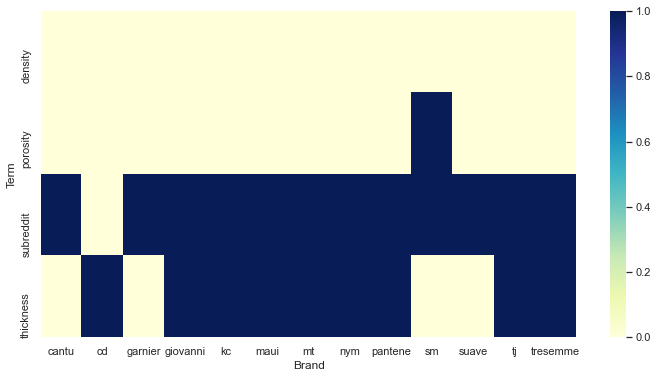

In [185]:

ax = sns.heatmap(chisq.pivot("Term", "Brand", "Reject"), cmap="YlGnBu")

In [167]:
posthoc_combo = pd.concat(posthoc_output)
posthoc_combo['TermsCombined'] = posthoc_combo['TermValue1'] + " vs. " + posthoc_combo['TermValue2']

In [176]:
posthoc_combo[posthoc_combo.Term == 'subreddit'].head()

,Brand,Term,TermValue1,TermValue2,Reject,Pval,TermsCombined
0,cantu,subreddit,r/curlyhair,r/naturalhair,True,0.000016,r/curlyhair vs. r/naturalhair
1,cantu,subreddit,r/curlyhair,r/wavyhair,False,0.060295,r/curlyhair vs. r/wavyhair
2,cantu,subreddit,r/naturalhair,r/wavyhair,True,0.005765,r/naturalhair vs. r/wavyhair
0,cd,subreddit,r/curlyhair,r/naturalhair,False,0.278404,r/curlyhair vs. r/naturalhair
1,cd,subreddit,r/curlyhair,r/wavyhair,False,0.834267,r/curlyhair vs. r/wavyhair


In [179]:
posthoc_combo[posthoc_combo.Term == 'subreddit'].pivot("TermsCombined", "Brand", "Reject")

Brand,cantu,cd,garnier,giovanni,kc,maui,mt,nym,pantene,sm,suave,tj,tresemme
TermsCombined,,,,,,,,,,,,,
r/curlyhair vs. r/naturalhair,True,False,True,True,False,True,True,True,True,True,True,False,True
r/curlyhair vs. r/wavyhair,False,False,True,True,False,True,True,True,False,False,False,True,True
r/naturalhair vs. r/wavyhair,True,False,True,True,True,True,True,True,True,True,True,True,True


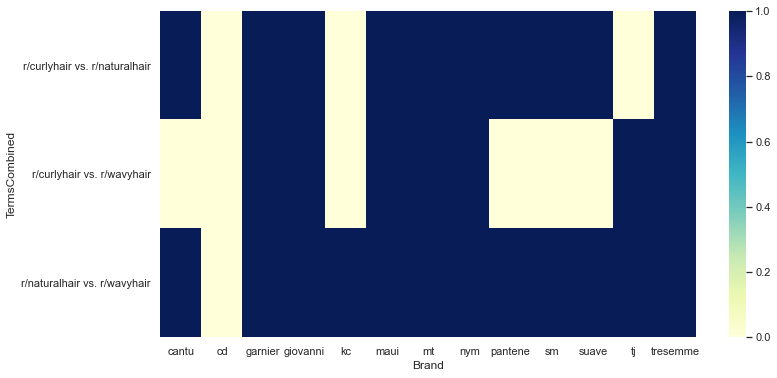

In [180]:
ax = sns.heatmap(posthoc_combo[posthoc_combo.Term == 'subreddit'].pivot("TermsCombined", "Brand", "Reject"), cmap="YlGnBu")

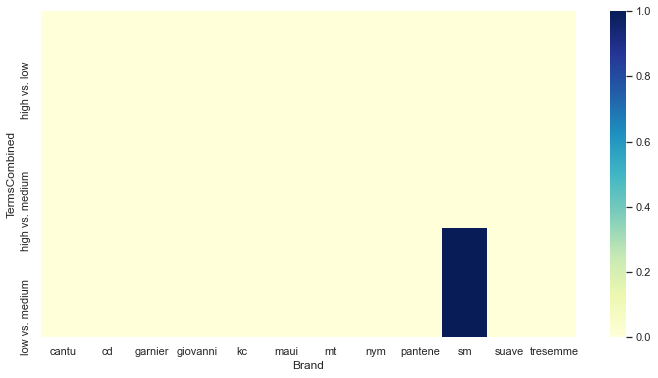

In [181]:
ax = sns.heatmap(posthoc_combo[posthoc_combo.Term == 'porosity'].pivot("TermsCombined", "Brand", "Reject"), cmap="YlGnBu")

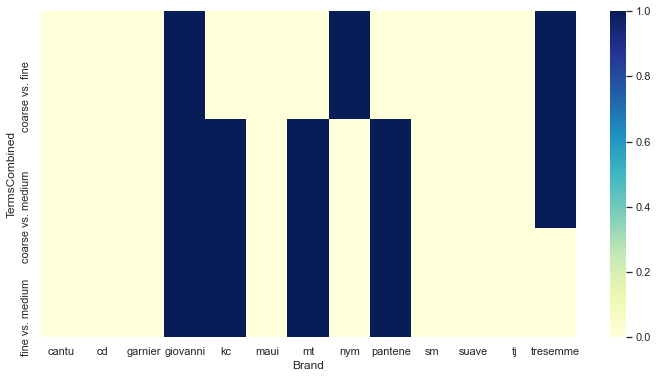

In [183]:
ax = sns.heatmap(posthoc_combo[posthoc_combo.Term == 'thickness'].pivot("TermsCombined", "Brand", "Reject"), cmap="YlGnBu")